### **Import Libraries**

In [2]:
%pip install matplotlib
%pip install seaborn
%pip install surprise
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

In [5]:
# Import the dataset
rating = pd.read_csv('dataset/ratings_Electronics.csv', names=['user_id', 'item_id', 'rating', 'timestamp'])
rating = rating.drop('timestamp', axis=1) # Dropping timestamp

In [6]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   item_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


### **Exploring the dataset**

In [7]:
# Printing the top 5 rows of the dataset
rating.head()

,user_id,item_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


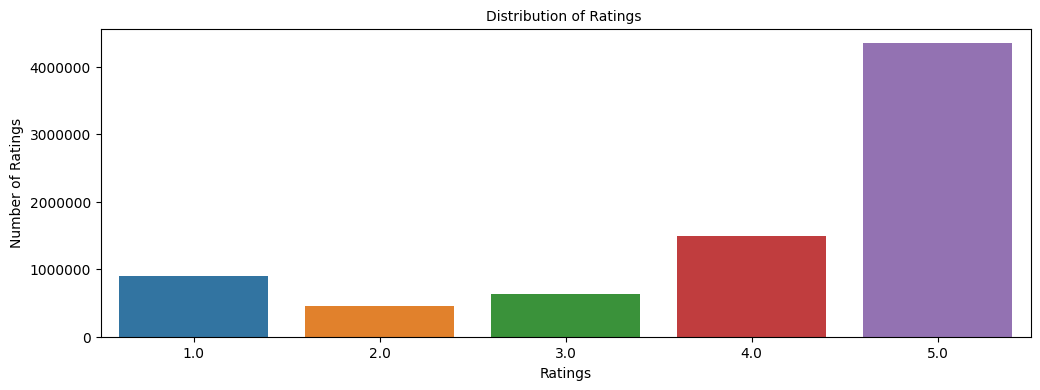

In [8]:
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()

In [9]:
# Copying the data to another DataFrame
df=rating.copy()

As this dataset is very large and has 7824482 observations, it is not computationally possible to build a model using this.Moreover, there are many users who have only rated a few products and also there are products which are rated by very less users. Hence we can reduce the dataset by considering certain Logical assumption.

Here, We will be taking users who have given at least 50 rating, and the products who has at least 5 rating, as when we shop online we prefer to have some number of rating of a product.

In [10]:
# Get the column containing the users
users = rating.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1  

In [11]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
rating = rating.loc[~rating.user_id.isin(remove_users)]

In [12]:
rating.shape

(125871, 3)

In [13]:
# Get the column containing the users
items = rating.item_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for item in items:
    # If we already have the user, just add 1 to their rating count
    if item in ratings_count:
        ratings_count[item] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[item] = 1    

In [14]:
# We want our item to have at least 5 ratings to be considred
RATINGS_CUTOFF = 5
remove_items = []
for item, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_items.append(item)
rating = rating.loc[~rating.item_id.isin(remove_items)]

In [15]:
rating.shape

(65290, 3)

In [16]:
# Finding number of unique users
rating['user_id'].nunique()

1540

In [17]:
# Finding number of unique items
rating['item_id'].nunique()

5689

- There are **5689 items** in the dataset
- As per the number of unique users and items, there is a **possibility of 1540 * 5689 = 8761060
 ratings** in the dataset. But **we only have 65290 ratings**, i.e. not every user has rated every item in the dataset. And we can build a recommendation system to recommend items to users which they have not interacted with.

In [18]:
rating.groupby(['user_id', 'item_id']).count()

rating
user_id        item_id           
A100UD67AHFODS B00004Z5M1       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002KVQBA       1
               B0002SQ2P2       1
...                           ...
AZOK5STV85FBJ  B005PQTYHE       1
               B006MPRFJQ       1
               B00AANMVNQ       1
               B00B25P27S       1
               B00FB2XNCE       1

[65290 rows x 1 columns]

In [19]:
rating.groupby(['user_id', 'item_id']).count()['rating'].sum()

65290

The sum is equal to the total number of observations which implies that there is only interaction between a pair of items and a user.

In [20]:
rating['item_id'].value_counts()

B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B00368CDH6      5
B0036AZA6A      5
B0036E8V08      5
B0036QL1JY      5
B00LGQ6HL8      5
Name: item_id, Length: 5689, dtype: int64

The Item with ItemId: B0088CJT4U has been interacted by most users which is 206 times.
But still, there is a possibility of 1540-206 = 1334 more interactions as we have 1540 unique users in our datasets. For those 1334 remaining users, we can build a recommendation system to predict who is most likely to interact with the item.
Also, out of these 1334 interactions, we need to consider the distribution of ratings as well.

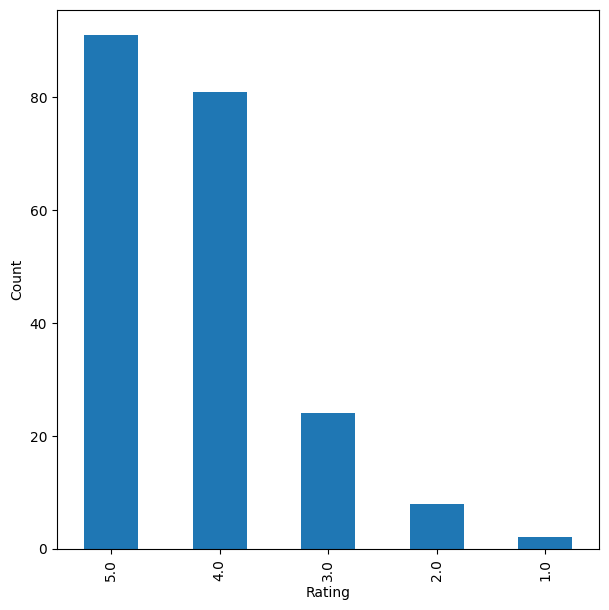

In [21]:
# Plotting distributions of ratings for 74 interactions with itemid B0088CJT4U
plt.figure(figsize=(7,7))

rating[rating['item_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

We can see that this item has been liked by the majority of users, as the count of ratings 5 and 4 is higher than the count of other ratings.
There can be items with very high interactions but the count of ratings 1 and 2 may be much higher than 4 or 5 which would imply that the item is disliked by the majority of users.

In [22]:
#Which user interacted the most with any item in the dataset
rating['user_id'].value_counts()

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
                 ... 
A16CVJUQOB6GIB      2
A2BGZ52M908MJY      2
A3DL29NLZ7SXXG      1
AP2NZAALUQKF5       1
A3MV1KKHX51FYT      1
Name: user_id, Length: 1540, dtype: int64

In [23]:
# Finding user-item interactions distribution
count_interactions = rating.groupby('user_id').count()['item_id']
count_interactions

user_id
A100UD67AHFODS     53
A100WO06OQR8BQ     77
A105S56ODHGJEK     58
A105TOJ6LTVMBG     32
A10AFVU66A79Y1     47
                 ... 
AZBXKUH4AIW3X      22
AZCE11PSTCH1L      23
AZMY6E8B52L2T     105
AZNUHQSHZHSUE      30
AZOK5STV85FBJ      14
Name: item_id, Length: 1540, dtype: int64

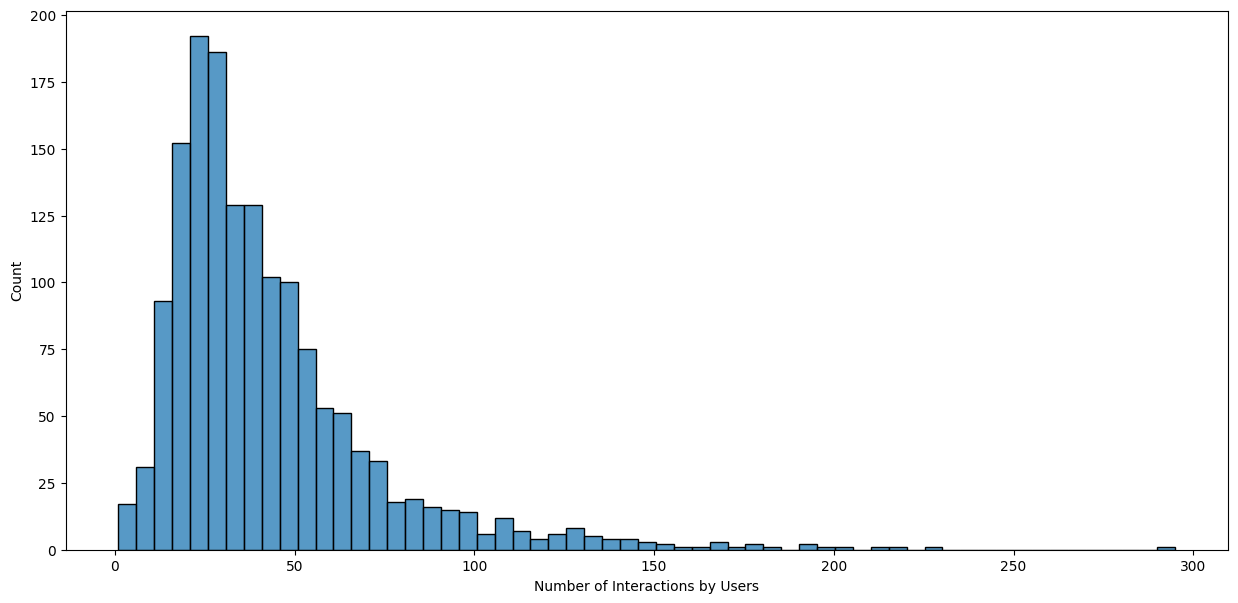

In [24]:
# Plotting user-item interactions distribution
plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

The distribution is higher skewed to the right. Only a few users interacted with more than 50 items.

## **Create Recommendation Model**

### **Model 1: Rank Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have cold start problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend items to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend items to the new user.

To build the rank-based recommendation system, we take average of all the ratings provided to each item and then rank them based on their average rating.

In [25]:
# Calculating average ratings
average_rating = rating.groupby('item_id').mean()['rating']

# Calculating the count of ratings
count_rating = rating.groupby('item_id').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [26]:
final_rating.head()

,avg_rating,rating_count
item_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


Now, let's create a function to find the top n items for a recommendation based on the average ratings of items. We can also add a threshold for a minimum number of interactions for a item to be considered for recommendation

In [27]:
def top_n_items(data, n, min_interaction=30):
    
    # Finding items with minimum number of interactions
    recommendations = data[data['rating_count'] >= min_interaction]
    
    # Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

In [28]:
#Recommending top 5 items with 50 minimum interactions based on popularity
list(top_n_items(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Model 2: Collaborative Filtering Based Recommendation System**

In this type of recommendation system, we do not need any information about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example -

- Ratings provided by users. For example - ratings of books on goodread, movie ratings on imdb etc
- Likes of users on different facebook posts, likes on youtube videos
- Use/buying of a product by users. For example - buying different items on e-commerce sites
- Reading of articles by readers on various blogs

Types of Collaborative Filtering

- Similarity/Neighborhood based

- - User-User Similarity Based
- - Item-Item similarity based

##### **Building a baseline user-user similarity based recommendation system**

- Below, we are building similarity-based recommendation systems using cosine similarity and using KNN to find similar users which are the nearest neighbor to the given user.
- We will be using a new library, called surprise, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [29]:
from sklearn.preprocessing import LabelEncoder

df=rating[['user_id','item_id']].apply(LabelEncoder().fit_transform)
df['rating']=rating['rating']
df.head()

,user_id,item_id,rating
1310,1050,0,5.0
1322,125,0,1.0
1335,785,0,3.0
1451,1495,0,5.0
1456,164,0,1.0


Below we are loading the rating dataset, which is a pandas DataFrame, into a different format called surprise.dataset.DatasetAutoFolds, which is required by this library. To do this, we will be using the classes Reader and Dataset. Finally splitting the data into train and test set.

In [30]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.7, random_state=42)

- Now, we are ready to build the first baseline similarity-based recommendation system using the cosine similarity.
- KNNBasic is an algorithm that is also associated with the surprise package. It is used to find the desired similar items among a given set of items.

In [31]:
sim_options = {'name': 'cosine',
               'user_based': True}

algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
algo_knn_user.fit(trainset)
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0552


1.0551559636074466

As we can see from above, these baseline model has RMSE=1.05 on test set, we will try to improve this number later by using GridSearchCV tuning different hyperparameters of this algorithm

**Predicted rating for an user with userId=0 and for itemId= 3906 and itemId=100**

In [32]:
algo_knn_user.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

As we can see - the actual rating for this user-item pair is 4 and predicted rating is 4.29 by this similarity based baseline model.

In case the user or the movie is very new, we do not have many records to predict results. In such cases, the last value in the prediction will appear as ‘was_impossible’: True.

In [33]:
algo_knn_user.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.0, details={'actual_k': 1, 'was_impossible': False})

As we can see the estimated rating for this user-item pair is 4.0 based on this similarity based baseline model

##### **Improving similarity based recommendation system by tuning its hyper-parameters**

Below we will be tuning hyper-parmeters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm: 
- k (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- min_k (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- sim_options (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise

   - cosine
   - msd (default)
   - pearson
   - pearson baseline

For more details please refer the official documentation https://surprise.readthedocs.io/en/stable/knn_inspired.html

**Perform hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system**

In [34]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [35]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.981736,0.972398,0.977604,0.977246,0.003821,12,0.728890,0.726615,0.727874,0.727793,0.000930,1,0.120975,0.008520,0.649401,0.015176,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.979329,0.968614,0.975330,0.974425,0.004421,9,0.732088,0.728405,0.731224,0.730572,0.001573,6,0.213074,0.015125,0.616188,0.007053,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.976145,0.962871,0.976078,0.971698,0.006242,6,0.748080,0.742259,0.748450,0.746263,0.002835,7,0.117628,0.002285,0.643737,0.032097,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.975844,0.962933,0.975531,0.971436,0.006014,3,0.750519,0.744628,0.750933,0.748693,0.002880,12,0.219050,0.005816,0.650381,0.006777,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.980251,0.969331,0.982705,0.977429,0.005813,15,0.760870,0.755674,0.762680,0.759741,0.002969,13,0.139283,0.032476,0.644868,0.004616,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


In [36]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=40, min_k=6,Verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9887


0.988698949219415

We can see from above that after tuning hyperparameters, RMSE for testset has reduced to 0.98 from 1.05. We can say that we have been able to improve the model after hyperparameter tuning

**Predicted rating for an user with userId=0 and for itemId= 3906 and itemId=100 using tuned user based collaborative filtering**

In [37]:
similarity_algo_optimized_user.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [38]:
similarity_algo_optimized_user.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=100, r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Identifying similar users to a given user (nearest neighbors)**

In [39]:
similarity_algo_optimized_user.get_neighbors(0, k=5)

[7, 12, 14, 23, 47]

##### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are -

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of items we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [40]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended item ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')
    
    # Extracting those item ids which the user_id has not interacted yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the item id which user_id has not interacted yet
    for item_id in non_interacted_items:
        
        # Predicting the ratings for those non interacted item ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # Returing top n highest predicted rating items for this user

**Predicted top 5 items for userId=4 with similarity based recommendation system**

In [41]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized_user)

In [42]:
recommendations

[(850, 5),
 (2857, 4.875),
 (2277, 4.856530910239044),
 (2722, 4.833333333333333),
 (4189, 4.833053684165744)]

### **Model 3: Item based Collaborative Filtering Recommendation System**

In [44]:
# Definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0697


1.0697030922594737

**predict rating for an user with userId=0 and for itemId=3906 and itemId=100**

In [45]:
algo_knn_item.predict(0, 3096, r_ui=4, verbose=True)

user: 0          item: 3096       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3096, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Let's predict the rating for the same userId=0 but for a item which this user has not interacted before i.e. itemId=22607**

In [46]:
algo_knn_item.predict(0, 100, verbose=True)

user: 0          item: 100        r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

**Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system**

In [48]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [49]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.990795,0.985123,0.988492,0.988137,0.002329,16,0.728116,0.727181,0.728897,0.728065,0.000701,1,0.848038,0.009807,0.985164,0.105018,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,0.989574,0.985717,0.988979,0.988090,0.001696,15,0.734191,0.733948,0.735739,0.734626,0.000793,6,1.462352,0.003727,0.940547,0.097700,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.974790,0.973943,0.975129,0.974621,0.000499,1,0.742498,0.741088,0.742276,0.741954,0.000619,7,0.841582,0.005539,0.870169,0.006635,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,0.976661,0.976927,0.977660,0.977083,0.000422,9,0.748630,0.747157,0.748446,0.748078,0.000656,12,1.457124,0.011687,0.995588,0.097104,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.976448,0.974818,0.976395,0.975887,0.000756,4,0.754054,0.752416,0.754429,0.753633,0.000874,13,0.844258,0.004357,0.960027,0.096591,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the final model by using tuned values of the hyperparameters which we received by using grid search cross-validation.

In [50]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9896


0.9895877571156905

**Predicted rating for an item with userId=0 and for itemId= 3906 and itemId=100 using tuned item based collaborative filtering**

**predict rating for an user with userId=0 and for itemId=3906**

In [52]:
similarity_algo_optimized_item.predict(0, 3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**redict the rating for the same userId=0 but for a item which this user has not interacted before i.e. itemId=100**

In [53]:
similarity_algo_optimized_item.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=100, r_ui=None, est=4.291366722826364, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### **Identifying similar users to a given user (nearest neighbors)**

find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the userId=4 based on the msd distance metric

In [54]:
similarity_algo_optimized_item.get_neighbors(4, k=5)

[132, 213, 473, 1636, 393]

Predicted top 5 items for userId=4 with similarity based recommendation system

In [55]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized_item)

In [56]:
recommendations

[(5155, 4.846153846153846),
 (1997, 4.701088473346358),
 (3975, 4.692622950819672),
 (4253, 4.612068965517241),
 (5489, 4.536817102137767)]

### **Model 4: Based Collaborative Filtering - Matrix Factorization using SVD**

Model-based Collaborative Filtering is a personalized recommendation system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use latent features to find recommendations for each user.

Latent Features: The features that are not present in the empirical data but can be inferred from the data. For example:

Singular Value Decomposition (SVD)
SVD is used to compute the latent features from the user-item matrix. But SVD does not work when we miss values in the user-item matrix.

**Building a baseline matrix factorization recommendation system**

In [59]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9309


0.9309444874408721

We can that the baseline RMSE for matrix factorization model on testset (which is 0.93) is lower as compared to the RMSE for baseline similarity based recommendation system (which is 1.06) and it is even lesser than the RMSE for optimized similarity based recommendation system (which is 0.99)

**predict rating for an user with userId=0 and for itemId=3906 as shown below**

In [60]:
algo_svd.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.52   {'was_impossible': False}


Prediction(uid=0, iid=3906, r_ui=4, est=4.520742478323958, details={'was_impossible': False})

**predicting rating for the same userId=0 but for a item which this user has not interacted before i.e. userId=100**

In [62]:
algo_svd.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.42   {'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.4189668113469525, details={'was_impossible': False})

***Improving matrix factorization based recommendation system by tuning its hyper-parameters***

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

**Perform hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system**

In [65]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8989561786699442
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Once the grid search is complete, we can get the optimal values for each of those hyperparameters, as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [66]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.955498,0.955646,0.951269,0.954138,0.002029,26,0.740794,0.738800,0.734172,0.737922,0.002774,25,0.699734,0.044493,0.407963,0.058855,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.955519,0.954183,0.951523,0.953742,0.001661,25,0.741975,0.738266,0.735746,0.738662,0.002558,26,0.808578,0.185778,0.392278,0.075733,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.956247,0.955193,0.951361,0.954267,0.002099,27,0.743719,0.741034,0.736700,0.740484,0.002892,27,0.680361,0.072628,0.338539,0.019730,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.913214,0.916084,0.909002,0.912767,0.002908,16,0.688130,0.687046,0.680231,0.685136,0.003496,16,0.633487,0.015806,0.349510,0.009375,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.914285,0.916933,0.910155,0.913791,0.002789,17,0.692762,0.691156,0.685393,0.689770,0.003164,17,0.686169,0.057236,0.426392,0.037789,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [67]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.9233


0.9232698281552618

predict rating for an user with userId=0 and for itemId=3906 with the optimized model

In [68]:
svd_algo_optimized.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.80   {'was_impossible': False}


Prediction(uid=0, iid=3906, r_ui=4, est=4.8008475403846225, details={'was_impossible': False})

In [69]:
svd_algo_optimized.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.55   {'was_impossible': False}


Prediction(uid=0, iid=100, r_ui=None, est=4.5460496738185405, details={'was_impossible': False})

**Predict the top 5 items for userId=4 with SVD based recommendation system**

In [71]:
get_recommendations(df,4, 5, svd_algo_optimized)

[(4638, 4.9645465509710105),
 (4886, 4.923811042855897),
 (1609, 4.91795316719284),
 (5, 4.903762311705211),
 (5068, 4.903151886405843)]

### **Predicting ratings for already interacted items**

Below we are comparing the rating predictions of users for those items which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [72]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended item ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')
    
    # Extracting those item ids which the user_id has interacted already
    interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the item id which user_id has interacted already
    for item_id in interacted_items:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted item ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['itemId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating items for this user

Here we are comparing the predicted ratings by similarity based recommendation system against actual ratings for userId=4

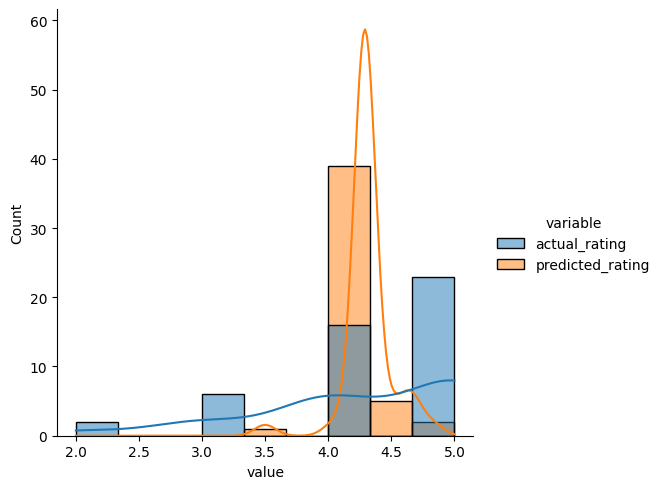

In [75]:
#similarity based recommendation system

predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,4, similarity_algo_optimized_user)
data = predicted_ratings_for_interacted_items.melt(id_vars='itemId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=data, x='value', hue='variable', kde=True);

- We can see that distribution of predicted ratings is closely following the distribution of actual ratings. The total bins for predicted ratings are nearly same as to the total bins for actual ratings.
- We are getting more predicted values in between 4 and 5,this is expected, as actual ratings always have discreet values like 1, 2, 3, 4, 5, but predicted ratings can have continuous values as we are taking aggregated ratings from the nearest neighbors of a given user. But over the predictions looks good as compared to the distribution of actual ratings.

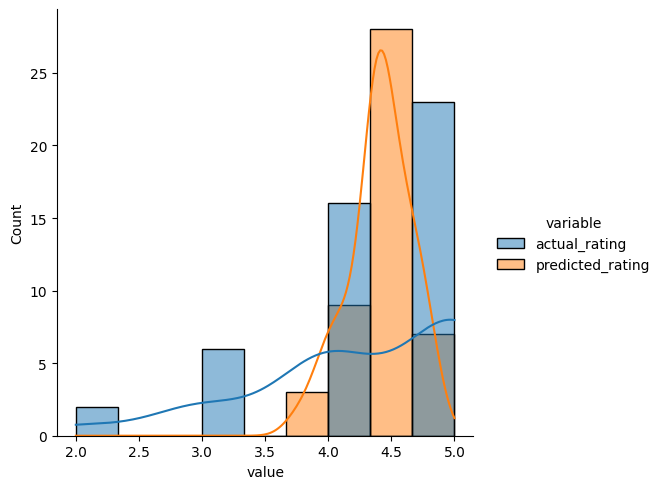

In [76]:
#matrix factorization based recommendation system

predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,4, svd_algo_optimized)
data = predicted_ratings_for_interacted_items.melt(id_vars='itemId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=data, x='value', hue='variable', kde=True);